# Практическое занятие 3

## Медицинское исследование: гипотеза, получение данных.  Генерация синтетических данных. Подготовка данных к анализу.

### Перед тем, как начать программировать, нам нужно выдвинуть научную гипотезу и проговорить, ЧТО мы хотим сделать

Иначе, эпидемиолог или заказчик, сделает предположение, что вы, сначала "помучали" данные, а потом, найдя, возможно, случайным образом, какие-то закономерности - предлагаете решение.
Хотя такой подход, в некоторых случаях, имеет право на жизнь, но, чаще всего, такой проект, будет забракован на стадии презентации.

---

**Научная гипотеза**

---

У нас есть данные с пациентами, пролеченными от коронавирусной инфекции (не только). Вирусная инфекция не требует назначения антибактериальной терапии, однако, нередки осложения в виде присоединения бактериального компонента.
Назначение антибиотиков может происходить на основании клинических данных, говорящих о том, что у пациента есть бактериальное осложнение, либо, используя лабораторный тест прокальцитонин. При повышении уровня прокальцитонина выше 0.5 - антимикробные препараты показаны.
Однако, этот лабораторный тест, не всегда доступен. В таком случае, врачом используется стратегия: если я не знаю есть или нет бактериального осложениния, я лучше назначу антибиотик, т.е. если я его назначу, когда микробов нет - особо ничего страшного; а если я не назнау антибиотик, когда он нужен - последствия будут плохие.
Таким образом, в некоторых больницах, при отсутствии прокальцитонина, уровень назначения антибиотиков у пациентов с коронавирусной инфекцией достигает 95 %, хотя, согласно исследованиям, нуждаются в этих препаратах около 15 % пациентов.
[Статья (необязательно)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7286278/)



> **Можем ли мы построить модель, предсказывающую показания к антибактериальной терапии, на основе данных эпикризов со значением прокальцитонина? (это и вопрос и гипотеза) **







## Медицинское обоснование и гипотеза сформирована, можно приступить к подготовке данных к выполнению исследования

Данный запрос на первый взгляд может показаться сложным и непонятным.
Суть его в том, что мы собираем все лабораторные значения и заболевания "вокруг" прокальцитонина (в какой-то мере, это можно назвать бутстрапированием), попутно "обогощая" данные положительным классом
(просто copy+paste)

```
-- procalcitonine  - concept_id - 27
-- шаг 1 - соберём всех пациентов с анализами прокальцитонина и в случае если нет значения - заменим значением 0.9
with proc as (select person_id, coalesce(value,  0.9) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 27),
fibr as (select person_id, coalesce(value,  4.9) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 6),
creat as (select person_id, coalesce(value,  109) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 7),
wbc as (select person_id, coalesce(value,  4.9) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 8),
hb as (select person_id, coalesce(value,  120) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 9),
plt as (select person_id, coalesce(value,  155) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 10),
crp as (select person_id, coalesce(value,  24) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 11),
esr as (select person_id, coalesce(value,  50) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 12),
lymph as (select person_id, coalesce(value,  20) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 13),
summ_measurement as (
select distinct proc.person_id as person_id, proc.measurement_date, proc.value procalcitonine, fibr.value fibrinogen,creat.value creatinine, wbc.value wbc,hb.value hb,plt.value plt,crp.value crp,
esr.value esr,lymph.value lymph from proc
left join fibr on proc.person_id = fibr.person_id and fibr.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join creat on proc.person_id = creat.person_id and creat.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join wbc on proc.person_id = wbc.person_id and wbc.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join hb on proc.person_id = hb.person_id and hb.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join plt on proc.person_id = plt.person_id and plt.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join crp on proc.person_id = crp.person_id and crp.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join esr on proc.person_id = esr.person_id and esr.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join lymph on proc.person_id = lymph.person_id and lymph.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3),
-- Шаг 2 - собрать болезни
pneumonia as (select person_id from gb_rwd."condition" where condition_concept_id = 1),
ihd as (select person_id from gb_rwd."condition" where condition_concept_id = 2),
dm as (select person_id from gb_rwd."condition" where condition_concept_id = 3),
covid as (select person_id from gb_rwd."condition" where condition_concept_id = 4),
ah as (select person_id from gb_rwd."condition" where condition_concept_id = 5),
-- Шаг 3 - создать результат путём объединения временных таблиц
 final_ as (select distinct sm.*, case when pneumonia.person_id is not null then 1 else 0 end as  pneumonia, case when ihd.person_id  is not null then 1 else 0 end as ihd,
case when dm.person_id  is not null  then 1 else  0 end as  dm, case when covid.person_id  is not null then 1 else 0 end as covid,  case when ah.person_id  is
not null then  1 else  0 end as ah
from summ_measurement sm
left join pneumonia on sm.person_id = pneumonia.person_id
left join ihd  on sm.person_id = ihd.person_id
left join dm  on sm.person_id = dm.person_id
left join covid on sm.person_id = covid.person_id
left join ah on sm.person_id = ah.person_id)

select f.*, v.concept_name sex, p.hospital_days len ,  date_of_birth, date_of_birth from final_ f
join gb_rwd.person p on p."person_id " = f.person_id
join gb_rwd.vocabulary v on p."sex_concept_id " = concept_id




```

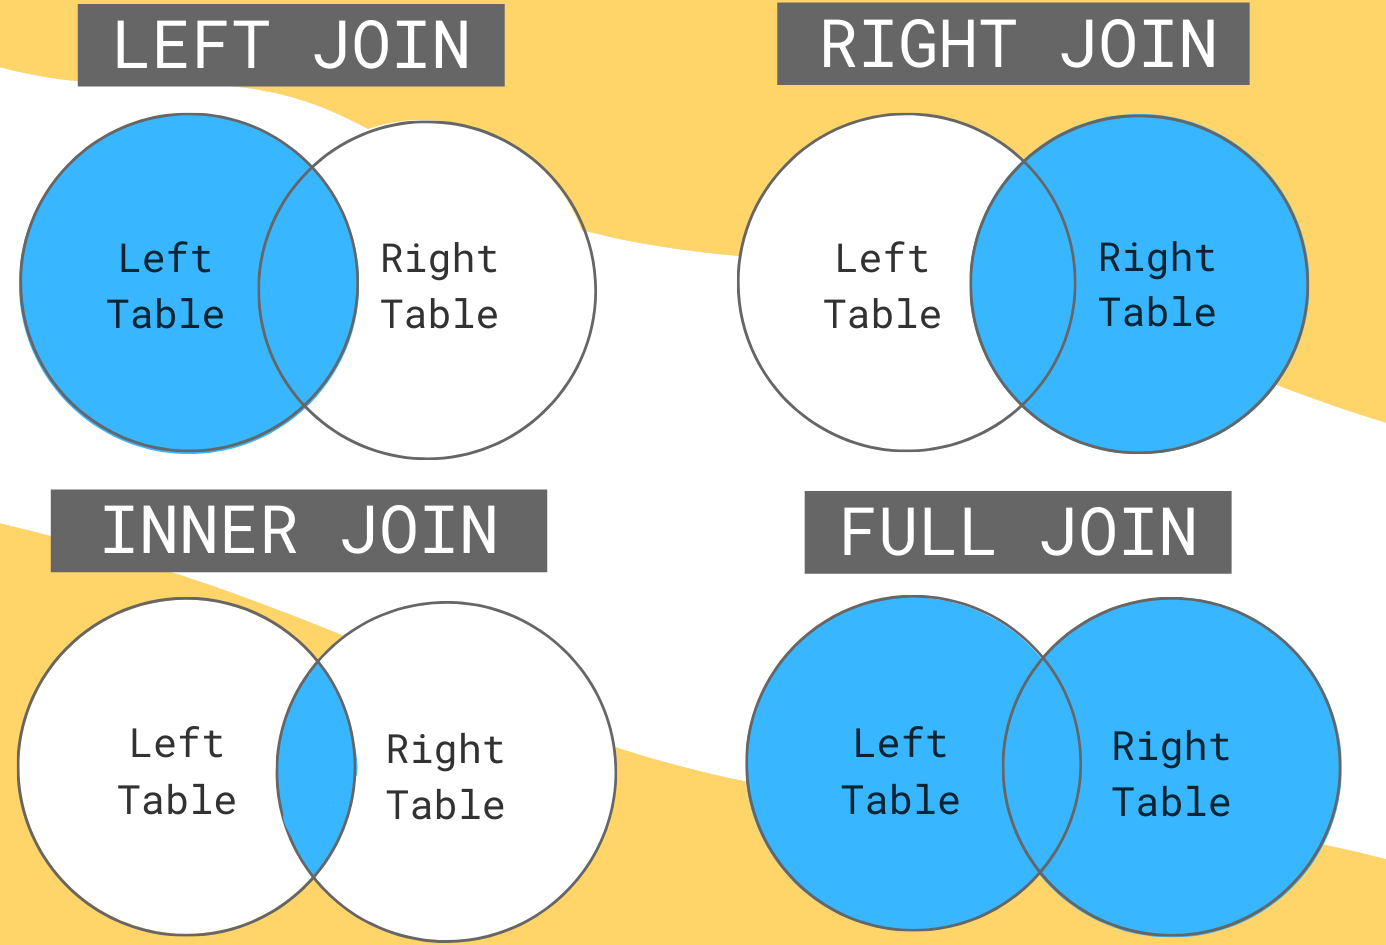

Но всё не совсем так...

Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import re

Загрузим подготовеленные данные

In [2]:
study_data =  read_csv('/Users/annvorosh/Documents/GB/NLPmed/L03/consolidated_data.csv')

In [3]:
dat = study_data.drop_duplicates()
dat.shape

(72827, 20)

In [4]:
dat.head()

,person_id,measurement_date,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,pneumonia,ihd,dm,covid,ah,sex,len,date_of_birth,date_of_birth.1
0,1068,2020-12-16,0.20,6.38,70.0,2.90,128.0,175.0,2.6,13.0,9.0,1,0,0,1,0,Женский,17,1952-07-28,1952-07-28
1,1068,2020-12-14,0.27,6.38,70.0,2.90,128.0,175.0,2.6,13.0,9.0,1,0,0,1,0,Женский,17,1952-07-28,1952-07-28
2,1073,2020-12-18,0.09,NaN,67.0,8.09,158.0,445.0,NaN,8.0,18.0,1,1,0,1,0,Женский,11,1959-02-05,1959-02-05
3,1073,2020-12-18,0.09,NaN,67.0,8.09,158.0,395.0,NaN,8.0,18.0,1,1,0,1,0,Женский,11,1959-02-05,1959-02-05
4,1073,2020-12-18,0.09,NaN,67.0,8.09,152.0,445.0,NaN,8.0,18.0,1,1,0,1,0,Женский,11,1959-02-05,1959-02-05


## Подготовка синтетических данных

Сделаем небольшое отступление от основной задачи.
Мы с вами обсуждали на лекции, что для работы с медицинскими данными нужно соблюсти множесто правил. Да и не все организации могут себе позволить "держать" у себя эти данные: и дорого, и проблемно.


> Есть решение - синтетические данные. Т.е. у вас есть "реальные данные", вы, используя интересные инструменты, делаете реалистичные данные и продаёти их, уже дешевле и без проблем с приватностью, win-win ситуация.






In [5]:
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()

In [6]:
metadata.detect_from_dataframe(data=dat)

In [7]:
from sdv.lite import SingleTablePreset

synthesizer = SingleTablePreset(metadata, name='FAST_ML')
synthesizer.fit(dat)

synthetic_data = synthesizer.sample(num_rows=1000000)

/opt/homebrew/lib/python3.11/site-packages/sdv/single_table/base.py:79: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [8]:
synthetic_data

,person_id,measurement_date,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,pneumonia,ihd,dm,covid,ah,sex,len,date_of_birth,date_of_birth.1
0,1056,2021-01-12,0.238188,9.549451,86.379753,34.280123,132.066000,288.856212,0.800000,NaN,9.768979,1,1,0,0,0,Мужской,44,1967-12-05,1967-12-04
1,299,2021-01-25,0.040123,10.639668,74.957708,4.158548,164.764883,595.942672,17.608098,11.756948,17.008910,1,0,0,1,0,Мужской,29,1967-04-25,1967-04-25
2,443,2021-01-09,0.216398,8.003499,67.962368,15.037247,143.543777,637.575005,97.593400,40.021439,9.434280,1,0,0,1,0,Мужской,24,1977-03-05,1977-03-07
3,324,2021-02-05,0.086046,11.126008,109.901860,31.580651,132.085325,165.162126,5.837929,24.540524,31.439091,1,1,0,1,0,Мужской,32,1957-10-05,1957-10-06
4,1103,2020-12-25,0.205600,3.916735,85.126649,31.709467,128.188138,146.800952,0.800000,38.561346,18.554760,1,1,1,0,0,Мужской,45,1966-10-17,1966-10-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1103,2020-12-27,0.118996,3.630481,85.579250,38.431536,132.156385,368.875538,66.075515,17.190992,10.045031,1,1,0,0,0,Женский,48,1958-08-09,1958-08-08
999996,1032,2021-01-19,0.177481,7.900326,109.852474,34.237706,129.012762,362.535448,0.800000,46.855221,18.633483,1,1,0,0,0,Мужской,52,1964-12-27,1964-12-27
999997,807,2021-01-15,0.095583,9.187326,96.794976,13.908418,121.349152,241.562851,0.800000,34.598432,11.043493,1,0,0,0,0,Мужской,38,1963-11-30,1963-11-29
999998,1103,2021-01-03,0.231561,8.272170,78.991242,37.725299,162.346160,49.085595,28.705350,18.540167,11.226961,1,1,0,0,0,Мужской,39,1967-03-24,1967-03-22


In [9]:
synthetic_data.shape

(1000000, 20)

In [10]:
synthetic_data.columns

Index(['person_id', 'measurement_date', 'procalcitonine', 'fibrinogen',
       'creatinine', 'wbc', 'hb', 'plt', 'crp', 'esr', 'lymph', 'pneumonia',
       'ihd', 'dm', 'covid', 'ah', 'sex', 'len', 'date_of_birth',
       'date_of_birth.1'],
      dtype='object')

## Подготовка данных для анализа (Feature Engineering)

In [11]:
synthetic_data['date_of_birth']  = pd.to_datetime(synthetic_data['date_of_birth'])

In [12]:
synthetic_data['measurement_date']  = pd.to_datetime(synthetic_data['measurement_date'])

In [13]:
synthetic_data['age'] =  synthetic_data['measurement_date'] - synthetic_data['date_of_birth']
synthetic_data['age'] = synthetic_data['age'].apply(lambda x: re.sub(' days .*', '', str(x)))

In [14]:
synthetic_data.age = synthetic_data['age'].apply(lambda x: round(int(x) / 364.2), 1)


<Axes: >

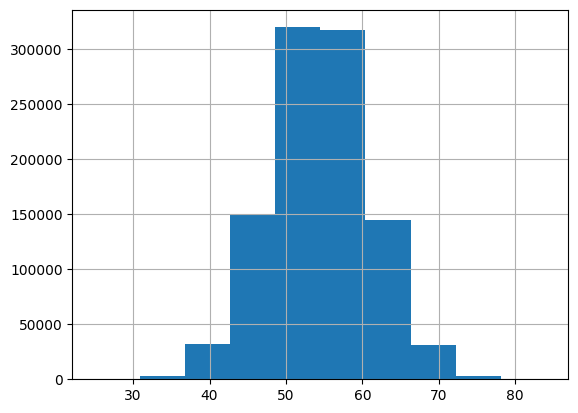

In [15]:
synthetic_data.age.hist()

In [16]:
# Конвертируем ммоль/л в мг/мл (для упрощения посчёта СКФ)
synthetic_data['creatinine'] = synthetic_data['creatinine'].apply(lambda x: x / 88.4)

*т.к. в наших данных есть параметр "креатинин", для того, чтобы улучшить
данные, давайте высчитаем скорость клубочковой
фильтрации. СКФ обладает значительно более высокой диагностической ценностью*

In [17]:
"""Levey AS, Stevens LA, Schmid CH, et al. for the CKD-EPI
(Chronic Kidney Disease Epidemiology Collaboration).
A New Equation to Estimate Glomerular Filtration Rate.
 Ann Intern Med. 2009 May 5; 150:604-612. PubMed ID: 19414839"""

if synthetic_data.sex.all() == 'Мужской':
    if synthetic_data.creatinine.all() < .9:
        synthetic_data['GFR'] = 141 * (((synthetic_data['creatinine'] /
                                  0.9)) ** (-0.411)) * 0.993 ** synthetic_data['age']
    else:
        synthetic_data['GFR'] = 141 * (((synthetic_data['creatinine'] /
                                  0.9)) ** (-1.209)) * 0.993 ** synthetic_data['age']
else:
    if synthetic_data.creatinine.all() < .7:
        synthetic_data['GFR'] = 144 * (((synthetic_data['creatinine'] /
                                  0.7)) ** (-0.329)) * 0.993 ** synthetic_data['age']
    else:
        synthetic_data['GFR'] = 144 * (((synthetic_data['creatinine'] /
                                  0.7)) ** (-1.209)) * 0.993 ** synthetic_data['age']


<Axes: >

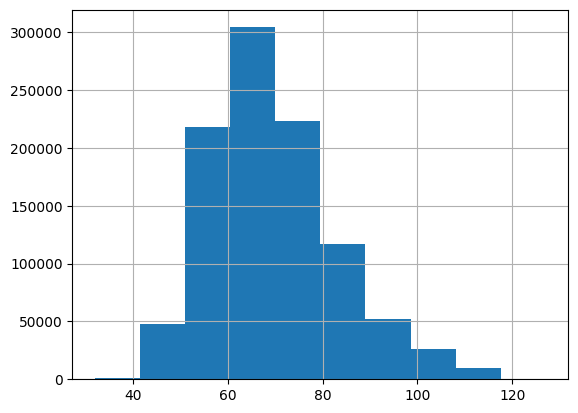

In [18]:
synthetic_data['GFR'].hist()

Определяем уровень прокальцитонина более .45, который является показанием для аб терапии

In [19]:
synthetic_data['ab_indication'] = np.where(synthetic_data['procalcitonine'] > 0.45, 1, 0)

# **<span style="color:#6daa9f;">Анализ данных</span>**

Визуализация данных


In [20]:
import seaborn as sns

<Axes: xlabel='ab_indication', ylabel='count'>

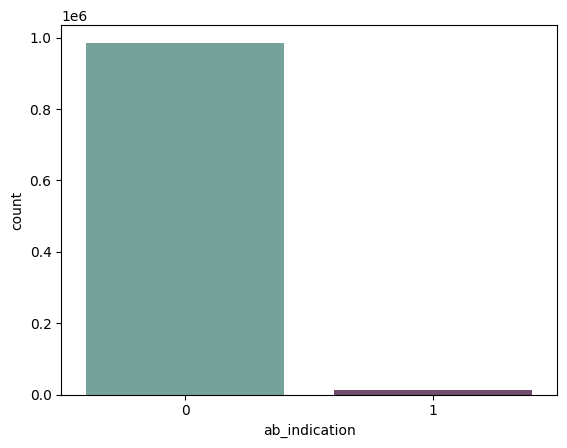

In [21]:
#Посмотрим на баланс данных
cols= ["#6daa9f","#774571"]
sns.countplot(x = synthetic_data["ab_indication"], palette= cols)

In [22]:
neg, pos = np.bincount(synthetic_data['ab_indication'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.1f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1000000
    Positive: 13853 (1.4% of total)



In [23]:
sex_map = {
    "Мужской": 1,
    "Женский": 0
}
synthetic_data.sex = synthetic_data.sex.map(sex_map)

In [24]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   person_id         1000000 non-null  int64         
 1   measurement_date  1000000 non-null  datetime64[ns]
 2   procalcitonine    1000000 non-null  float64       
 3   fibrinogen        766700 non-null   float64       
 4   creatinine        999879 non-null   float64       
 5   wbc               999837 non-null   float64       
 6   hb                999874 non-null   float64       
 7   plt               999723 non-null   float64       
 8   crp               999222 non-null   float64       
 9   esr               848718 non-null   float64       
 10  lymph             999162 non-null   float64       
 11  pneumonia         1000000 non-null  int64         
 12  ihd               1000000 non-null  int64         
 13  dm                1000000 non-null  int64  

In [25]:
synthetic_data.columns

Index(['person_id', 'measurement_date', 'procalcitonine', 'fibrinogen',
       'creatinine', 'wbc', 'hb', 'plt', 'crp', 'esr', 'lymph', 'pneumonia',
       'ihd', 'dm', 'covid', 'ah', 'sex', 'len', 'date_of_birth',
       'date_of_birth.1', 'age', 'GFR', 'ab_indication'],
      dtype='object')

In [26]:
df = synthetic_data.loc[:, ['procalcitonine', 'fibrinogen',
       'creatinine', 'wbc', 'hb', 'plt', 'crp', 'esr', 'lymph', 'pneumonia',
       'ihd', 'dm', 'covid', 'ah', 'sex', 'len',  'age', 'GFR', 'ab_indication']]

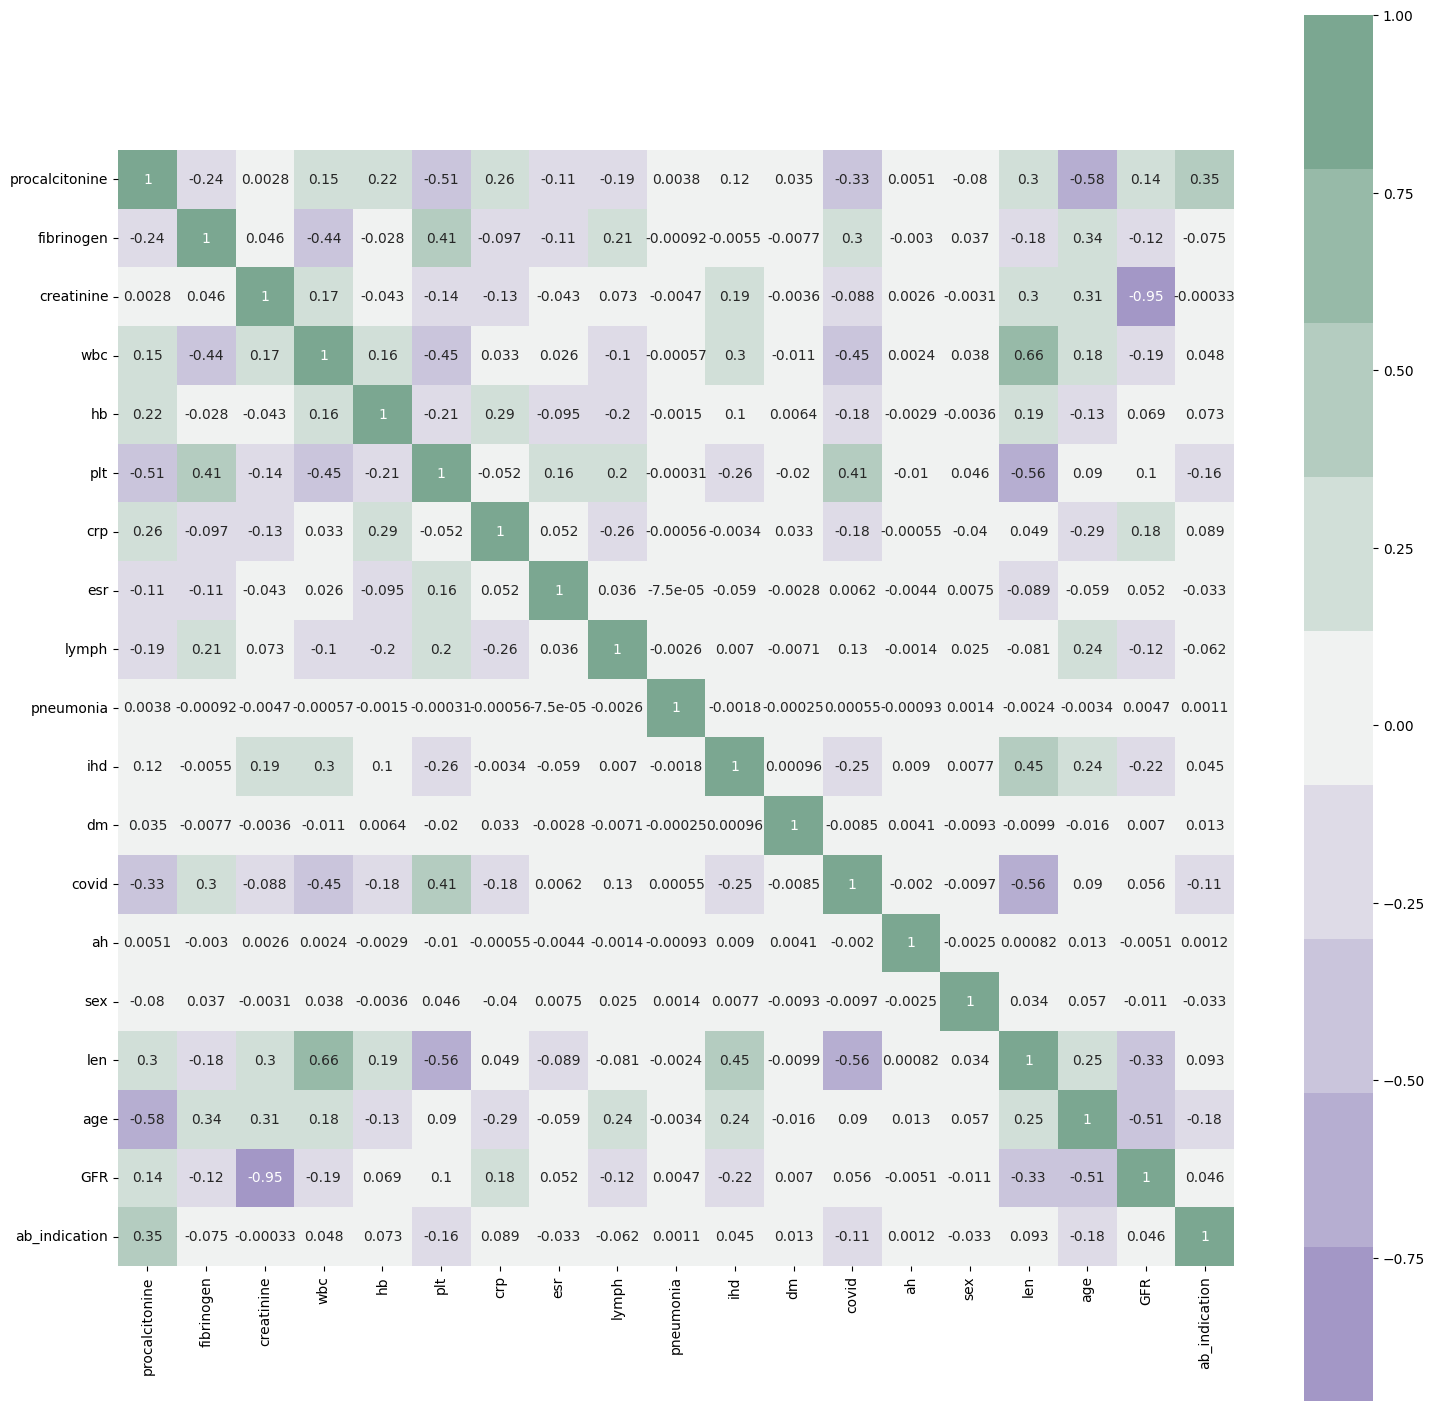

In [27]:
#Построим корреляционную матрицу
import matplotlib.pyplot as plt
cmap = sns.diverging_palette(275,150,  s=40, l=65, n=9)
corrmat = df.corr()
plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat, cmap= cmap, annot=True, square=True);

### ВЫВОДЫ
Рассмотрим три большие корреляции из представленной матрицы:

#### 1. 0.951719 (креатинин и GFR):
Уровень креатинина в крови часто используется в качестве показателя функции почек. Повышенные уровни креатинина свидетельствуют о снижении функции почек, поскольку креатинин выделяется через почки. Поэтому увеличение уровня креатинина обычно сопровождается уменьшением скорости клубочковой фильтрации.

#### 2. 0.660455 (количество лейкоцитов и длина пребывания в больнице):
Увеличение количества лейкоцитов обычно связано с иммунным ответом на инфекцию или воспаление. Следовательно, более высокое количество лейкоцитов может указывать на более серьезное заболевание, требующее длительного пребывания в больнице для лечения.

#### 3. 0.580404 (возраст и GFR):
С возрастом часто происходит естественное снижение функции почек, связанное с уменьшением числа и функциональности нефронов. Поэтому увеличение возраста обычно сопровождается уменьшением скорости клубочковой фильтрации.

# Домашнее задание

- **Описание задания**:
Когда пациент принимает какое-либо лекарство, у него может возникнуть побочный эффект от лекарства или побочную реакцию на лекарство (ADR). Мы можем использовать [CUI](https://www.nlm.nih.gov/research/umls/new_users/glossary.html#:~:text=CUI%20-%20The%20Concept%20Unique%20Identifier%20for%20a%20Metathesaurus%20concept%20to%20which%20strings%20with%20the%20same%20meaning%20are%20linked.%20One%20of%20the%20principles%20of%20the%20Metathesaurus%20is%20that%20meanings%20should%20be%20preserved%20over%20time%20regardless%20of%20what%20terms%20(atoms)%20are%20used%20to%20express%20those%20meanings.), уникальный идентификатор концепта для  Metathesaurus, чтобы определить, какие нежелательные реакции упоминаются в сообщениях пациентов. обзоры лекарств в структурированном виде.

   Цель этого задания – помочь вам научиться идентифицировать (ADR) по описаниям пациентов о нежелательных реакциях на лекарственные препараты. Вы сможете:
  - Используйте подход NLP для извлечения побочных эффектов из обзоров лекарств.

## Уровни сложности извлечения концептов
- Давайте рассмотрим один из способов классификации сложности извлечения ADR на основе сравнения их представления с представлением CUI.
- Это всего лишь один из способов взглянуть на это, но он поможет вам выработать подход к захвату как можно большего количества явлений.

#### 1-й уровень
- На уровне 1 вы обнаружите, что слова, описывающие нежелательную реакцию, точно такие же, как понятия CUI.
> Вот пример:
> - Sentence text: `I was unable to sleep, had blurred vision, and felt sick to my stomach.`
> - ADR: **blurred vision**
> - CUI concept: **blurred vision**
> - CUI: **C0344232** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

- Кроме того, слова определяются как «одинаковые», даже если они представляют собой разные производные (обычно разные суффиксы в английском языке) одного и того же слова. Те же леммы или те же основы примерно.
>Вот еще один пример, который в этом наборе данных считается уровнем 1:
> - Sentence text: `Muscle spasms, muscle twitching, muscle soreness, insomnia, mental confusion, flush, brain zaps.`
> - ADR: **flush**
> - CUI Concept: **flushing**
> - CUI: **C0016382** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

#### Уровень 2
- На уровне 2 вы можете обнаружить, что слова, описывающие нежелательную реакцию, совпадают с понятиями CUI, хотя порядок слов может быть другим.
> Вот пример:
> - Sentence text: `Weight gain, HAIR LOSS, increased depression, fatigue, lethargy.`
> - ADR: **HAIR LOSS**
> - CUI concept: **Loss of hair**
> - CUI: **C0002170** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

#### Уровень 3
- На уровне 3 вы можете обнаружить, что, помимо разницы в порядке слов, только некоторые слова, описывающие нежелательную реакцию, точно такие же, как в понятиях CUI.
> Вот пример:
> - Sentence text: `It's been four days since I discontinued, and I'm still wiped out and dizzy with flu-like symptoms.`
> - ADR: **flu-like symptoms**
> - CUI concept: **Influenza-like symptoms**
> - CUI: **C0392171** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

#### Уровень 4
- На уровне 4 вы обнаружите, что ни одно из слов, описывающих нежелательную реакцию, не совпадает со словами в концепциях CUI, но при этом имеет то же значение.
> Вот пример:
> - Sentence text: `Also I had a severe inablility to concentrate which made it impossible to do my job,I am a Registered Nurse.`
> - ADR: **impossible to do my job**
> - CUI concept: **Restricted work performance**
> - CUI: **C0557386** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

#### Уровень 5 &nbsp; &nbsp; (От вас не ожидается, что вы их решите)
- На уровне 5 вы можете обнаружить, что слова, описывающие побочную реакцию, не совпадают с понятиями CUI и имеют разные значения. ADR может предлагать концепцию CUI посредством следствия или посредством какого-либо другого лингвистического или контекстуального механизма. Если вы сумеете их идентифицировать, это будет очень впечатляюще!
> Вот пример:
> - Sentence text: `20 pounds total in 6 months Appetite increase .`
> - ADR: **20 pounds total**
> - CUI concept: **Body Weight Changes**
> - CUI: **C0005911** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

## Предоставленные файлы
Один из файлов, которые у вас есть для этого задания, называется «побочные_эффекеты.txt». Обзоры лекарств разделены предложением. Для каждой строки есть «row_id» и «sentence_text», разделенные табуляцией.

> Вот пример:
`7<tab>I was unable to sleep, had blurred vision, and felt sick to my stomach.`

Другой файл называется CUI_concepts.txt. АПИ и текст его концепции указаны в каждой строке.

> Вот пример:
`C0344232<tab>Blurred vision,Blurring of visual image`

# Шаблоны кода

##### Пожалуйста, измените шаблон кода настолько, насколько захотите. Вы можете использовать любые стандартные функции Python или, если хотите, написать свои собственные вспомогательные функции!

### Шаг 1: Чтение файла данных
- Попробуйте распечатать несколько строк и посмотреть примеры в наборе данных, с которым вы работаете. Вы будете протестированы на небольшом подмножестве из них, но ваши функции должны применяться в целом.

In [28]:
with open('/Users/annvorosh/Documents/GB/NLPmed/L03/побочные_эффекеты.txt') as file:
  documents = file.readlines()

# напечатаем первые 5 строк файла.
# Не стесняйтесь просматривать любое количество
print(*documents[:5], sep = '\n')

id	Text

1	extreme weight gain, short-term memory loss, hair loss.

2	COMPLETELY DESTROYED SEXUALLY FUNCTIONING .

3	Just TWO tablets of Lexapro 10mg completely destroyed my sexual functioning, probably for life.

4	It's called PSSD: post-SSRI sexual dysfunction.



### Шаг 2. Считайте файл CUI и сохраните его для удобного поиска.
- Сохраните все CUI и соответствующие им ключевые слова.
— Идея такая: пройтись по каждому CUI, чтобы определить, присутствует ли он в данном текстовом сегменте.

In [29]:
cuinames = []
concepts = []
with open('концепты.tsv') as cuifile: # CUI явления
  print(next(cuifile))  # пропустите заголовок, распечатайте, чтобы увидеть структуру строки
  for i, line in enumerate(cuifile):
    fields = line.split('\t')
    # удалите конечные пробелы (и нечетные случайные nbsp...)
    cui = fields[0].strip()
    # храните различные текстовые представления концептов
    # но отбросьте дублирующиеся текстовые представления для одного и того же концепта
    texts = set(f.strip() for f in fields[1].split(','))
    for t in texts:
      # всегда добавляйте вместе, чтобы обеспечить одинаковый индекс
      cuinames.append(cui)
      concepts.append(t.strip().lower())

CUI	CONCEPT	SNOMED_CODE



In [30]:
print(len(concepts), len(cuinames))  # проверка на вменяемость
# распечатайте несколько CUIs. Исследуйте CUIs, пробуя различные диапазоны,
# или распечатайте весь список, если хотите.
for i in list(range(42,77)):
  print('CUI: {}\tConcept: {}'.format(cuinames[i], concepts[i]))

738 738
CUI: C0231528	Concept: muscle pain
CUI: C0009676	Concept: confusional state
CUI: C0009676	Concept: confusion
CUI: C0016382	Concept: flushing
CUI: C0016382	Concept: face goes red
CUI: C0033893	Concept: tension headache
CUI: C0033893	Concept: tension-type headache
CUI: C0700590	Concept: increased sweating
CUI: C0700590	Concept: excessive sweating
CUI: C0242350	Concept: erectile dysfunction
CUI: C0242350	Concept: impotence
CUI: C0149931	Concept: migraine disorders
CUI: C0149931	Concept: migraine
CUI: C0497247	Concept: finding of increased blood pressure
CUI: C0497247	Concept: increase in blood pressure
CUI: C0235195	Concept: sedated
CUI: C0235195	Concept: sedated state
CUI: C0424444	Concept: clenching teeth
CUI: C0234022	Concept: orgasm incapacity
CUI: C0456820	Concept: loss of capacity to feel emotions
CUI: C0002622	Concept: amnesia
CUI: C0233469	Concept: blunted affect
CUI: C0233484	Concept: emotionally detached
CUI: C0233794	Concept: memory impairment
CUI: C0701810	Concept: poo

## Шаг 3: Извлечение концептов

### Уровень 1 — Точное совпадение
- Давайте начнем с извлечения примеров только уровня 1. Все, что нам нужно сделать, это посмотреть, совпадают ли точные слова:
   - Сначала выберем метод предварительной обработки.
   - Тогда мы извлечем АДР

### Предварительная обработка 1
Давайте решим, как преобразовать (нормализовать) наш текст, чтобы нам было легче работать с вводом и CUI.
   — Мы начнем с токенизации текста, чтобы у нас был список слов, а не одна строка.
   - Кроме того, мы можем сократить текст, чтобы позаботиться о большинстве терминов, связанных с словообразованием!
     - То есть слова с одной основой, но с разными приставками, суффиксами или, возможно, различиями в середине слова. &nbsp; Обычно не все словообразовательные формы слов могут быть обработаны стеммером, поэтому это несовершенный метод. &nbsp; Это нормально!
     - Помните, что даже несмотря на то, что это удобно для сопоставления слов с похожими корнями, стемминг всегда удаляет потенциально полезную семантическую информацию (есть причины, по которым мы говорим С суффиксами). &nbsp; Часто нам хотелось бы получить не только основу, но и сохранить необработанную форму, чтобы иметь больше информации. &nbsp; Для данной задачи это может не потребоваться.
   - В любом случае, мы применим эту предварительную обработку как к CUI, так и к предложениям, чтобы мы могли воспользоваться их преобразованием одинаковым образом.
   - Вы можете решить проблему по-своему.

In [31]:
from string import punctuation as punct
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Это предложение для первого уровня.
# Убедитесь, что вы понимаете, что он делает, что в этом может помочь

def text_preprocessing_1(sentence):
    """Read in a sentence and return a list of tokens
       which are lower case and punctuation free.
       sentence must be a string"""
     # убираем знаки препинания из предложения и заменяем их на ' '
     # (пункт взят из строкового модуля, импортированного выше)
    s = sentence.translate(sentence.maketrans(punct, ' '*len(punct)))
    # простая токенизация
    toks = s.split()
    # нижний регист
    lowered = [w.lower() for w in toks]
    stemmed = [porter_stemmer.stem(w) for w in lowered]

    return stemmed

### Проверка концептов 1
- Заполните следующую заглушку функции, чтобы извлечь примеры концепций уровня 1.
- Эти функции проверки концептов должны возвращать ТОЛЬКО ИСТИНА или ЛОЖЬ. Вам не нужно указывать, где в тексте находится ДОПОГ или что представляет собой текст, представляющий ДОПОГ.
- Не стесняйтесь использовать любые встроенные функции Python или определять свои собственные, которые помогут вам!
- Вы будете протестированы на комбинированной реализации `text_preprocessing_1()` и `check_concept_1()`. Изменение `text_preprocessing_1()` не является обязательным!

In [32]:
# 1 уровень кода
# def check_concept_1(concept, sentence):
#     """Проверяет, упоминается ли в предложении концепт CUI.
#     Возвращает TRUE, если концепт присутствует, FALSE - если нет"""
#     # Предварительная обработка понятия и предложения
#     c_lst = text_preprocessing_1(concept.lower())
#     s_lst = text_preprocessing_1(sentence.lower())

#     # Проверяем, если слова из понятия присутствуют в предложении
#     for word in c_lst:
#         if word in s_lst:
#             return True

#     return False


def check_concept_1(concept, sentence):
    """Проверяет, упоминается ли в предложении концепт CUI.
    Возвращает TRUE, если концепт присутствует, FALSE - если нет"""
    # Предварительная обработка понятия и предложения
    c_lst = text_preprocessing_1(concept.lower())
    s_lst = text_preprocessing_1(sentence.lower())

    # Проверяем, если слова из понятия присутствуют в предложении
    if c_lst and s_lst:
        for word in c_lst:
            if word in s_lst:
                return True

    return False


Подсказка: если текст понятия является подпоследовательностью предложения, то в предложении имеется точное совпадение понятия.

Ниже приведены несколько примеров уровня 1. Ваша реализация `check_concept_1()` должна возвращать True для этих входных данных.

In [33]:
# пример уровеня 1
concept1_1 = 'Blurred vision' # то же CUI как 'Blurring of visual image'
sentence1_1 = 'I was unable to sleep, had blurred vision, and felt sick to my stomach.'

ans1_1 = check_concept_1(concept1_1, sentence1_1) # должно быть True!
print(bool(ans1_1))   # должен печатать True

concept2_1 = ''
sentence2_1 = ''

True


In [34]:
concept2_1 = 'Sleep Deprivation'
sentence2_1 = 'I have been suffering from sleep deprivation lately.'

ans2_1 = check_concept_1(concept2_1, sentence2_1) 
print(bool(ans2_1))   # должно быть True


True


In [35]:
concept1_1 = 'Blurred vision'
sentence1_1 = 'I was unable to sleep, had blurred vision, and felt sick to my stomach.'

concept2_1 = 'Sleep Deprivation'
sentence2_1 = 'I have been suffering from sleep deprivation lately.'

assert(check_concept_1(concept1_1, sentence1_1))
assert(check_concept_1(concept2_1, sentence2_1))
# исключение

In [36]:
# Убедитесь, что вы реализуете каждый уровень по очереди.
# (Не заставляйте check_concept_1() возвращать True для (многих) примеров уровня 2, 3 или 4)

## Уровень 2 — Точное совпадение, возможно, не по порядку

- Теперь мы хотим посмотреть, появляются ли понятия, но не обязательно со словами в правильном порядке.
- Есть много способов справиться с этим.&nbsp; Некоторые найдут больше, чем другие, и многие из них вызовут ложные срабатывания.
- Вам предстоит найти баланс для каждого уровня. Почти всегда будут компромиссы.

### Предварительная обработка 2
- Для уровня 1 мы токенизировали текст и убрали знаки препинания.
- Вы могли заметить, что в приведенном выше примере концептов уровня 2 («ВЫПАДЕНИЕ ВОЛОС» от «Потеря волос») слова не только были не в порядке, но также включали слово между ними. Это действительно характерно для концепций «не по порядку», поскольку изменение порядка слов и добавление предлога между ними (или удаление предлога и изменение порядка) часто имеет аналогичное значение в английском языке (и, конечно же, в других языках могут быть аналогичные явления).
- Это сильно зависит от точных слов, и нам не следует слишком увязнуть в деталях, потому что мы можем просто удалить все наиболее распространенные «функции» или «стоп-слова», чтобы «решить» эту проблему.
- Такие слова, как «the», «of» и даже «and», играют важную роль в формировании точного значения, но их удаление не должно создать особых проблем для задачи, поставленной уровнем 2:

In [37]:
# они импортируются снова, если вы сначала не запустите приведенный выше код!
from string import punctuation as punct
import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def text_preprocessing_2(sentence, stemm=True):
    """Прочитайте предложение и верните список токенов, в которых нет основы, нет знаков препинания и стоп-слов.
        предложение должно быть строкой"""
    # Все предоставленное text_preprocessing_1 в одной строке
    toks = [porter_stemmer.stem(w.lower()) if stemm else w.lower() for w in
             sentence.translate(sentence.maketrans(punct, ' '*len(punct))).split()]
    # toks = text_preprocessing_1(sentence) # эквивалентно, если вы не меняли text_preprocessing_1

    # Получить список стоп-слов из известного источника
    stopwords = nltk.corpus.stopwords.words('english')

    no_stopword = [tok for tok in toks if tok.lower() not in stopwords]
     # Вы можете изменить эту функцию, если считаете, что она вам поможет.
     # Не стесняйтесь добавлять или удалять шаги!

    final = no_stopword
    return final

### Проверка концептов 2
- Заполните следующую заглушку функции, чтобы извлечь примеры концептов уровня 2.
- Не стесняйтесь использовать любые встроенные функции Python или определять свои собственные, которые помогут вам, если вы захотите!
- Вы снова будете протестированы на комбинированной реализации `text_preprocessing_2()` и `check_concept_2()`, причем изменение `text_preprocessing_2()` снова будет необязательным.

In [38]:
# 2 уровень кода
def check_concept_2(concept, sentence):
    """Проверьте, упоминается ли в предложении концепция CUI. Верните TRUE, если концепция присутствует, и повторите FALSE, если нет."""
    # предварительная обработка понятия и предложения
    c_lst = text_preprocessing_2(concept)
    s_lst = text_preprocessing_2(sentence)

    # Проверка присутствия всех токенов концепции в предложении
    for token in c_lst:
        if token not in s_lst:
            return False

    return True


In [39]:
#пример 2 уровня
concept1_2 = 'Loss of hair'
sentence1_2 = 'His hair loss has been gradual, but he is concerned about it worsening in the future.'

ans1_2 = check_concept_2(concept1_2, sentence1_2) # должен быть True!
print(bool(ans1_2))   # должен быть True

concept2_2 = 'Face goes red'
sentence2_2 = 'His face often goes red when he feels embarrassed or nervous.'
ans2_2 = check_concept_2(concept2_2, sentence2_2) # должен быть True!
print(bool(ans2_2))

True
True


In [40]:
# скопируйте примеры
assert(check_concept_2(concept1_2, sentence1_2))
assert(check_concept_2(concept2_2, sentence2_2))
# исключение

## Уровень 3 - Слова схожего значения, но разного корня
- В отличие от уровней 1 и 2, где необходимо было идентифицировать слова с одним и тем же корнем, но разной формой, на уровне 3 возникает необходимость идентифицировать слова с существенно отличающейся формой, но имеющими «достаточно схожее» значение.
- На уровне 3 вы можете попытаться рассматривать эти пары слов, которые «достаточно похожи», как совпадения слов. Вы можете обнаружить, что это работает.
- Вы также можете не слишком полагаться на сопоставление слов и придумать другие методы для извлечения большего количества ADR из уровня 3. Это открытый метод, и если вам кажется более естественным другой подход, вы можете попробовать его.

### Предварительная обработка 3
- Как вы узнаете, имеют ли слова схожее значение? Есть ли какие-либо ресурсы, о которых вы узнали, которые вы можете использовать? Поможет ли вам изменение подхода к предварительной обработке? Не у всех будут одинаковые ответы на эти вопросы.
— Таким образом, опять же, смело придумывайте свой подход к предварительной обработке.

In [41]:
import string
import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def text_preprocessing_3(sentence, stemm=True):
    """Прочитайте предложение и верните список токенов, в которых нет основы, нет знаков препинания и стоп-слов."""
    toks = [porter_stemmer.stem(w.lower()) if stemm else w.lower() for w in
                sentence.translate(sentence.maketrans(string.punctuation, ' '*len(string.punctuation))).split()]
    # НЕ забудьте скачать стоп слова
    stopwords = nltk.corpus.stopwords.words('english')
    no_stopword = [tok for tok in toks if tok.strip() not in stopwords]

    ### ВЫ МОЖЕТЕ ДОБАВИТЬ ВСЕ, ЧТО СЧИТАЕТЕ, МОЖЕТ БЫТЬ ПОЛЕЗНЫМ ###

    final = no_stopword
    return final

### Проверьте концепты 3
- Заполните заглушку функции ниже, чтобы завершить подход уровня 3.
- Вероятно, вам понадобится ресурс, который подскажет вам, насколько похожи слова!

In [42]:
# 3 уровень кода
# импортируйте библиотеки, если надо

def check_concept_3(concept, sentence):
    """Проверьте, упоминается ли в предложении концепция CUI. Возвращайте TRUE, если концепция существует, и возвращайте FALSE, если нет."""
    c_lst = text_preprocessing_3(concept)
    s_lst = text_preprocessing_3(sentence)

    # Проверяем, если хотя бы один токен из понятия присутствует в предложении
    for c_token in c_lst:
        if c_token in s_lst:
            return True

    return False


In [43]:
concept3 = 'Severe vertigo'
sentence3 = 'Emergency Room visit with tachycardia and violent vertigo.'

check_concept_3(concept3, sentence3)

True

## Уровень 4
- На уровне 4 вы обнаружите, что ни одно из слов, описывающих нежелательную реакцию, не совпадает со словами в концепциях CUI, но при этом имеет то же значение.
> Вот пример:
> - Sentence text: `Also I had a severe inablility to concentrate which made it impossible to do my job,I am a Registered Nurse.`
> - ADR: **impossible to do my job**
> - CUI concept: **Restricted work performance**
> - CUI: **C0557386** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

Для обработки таких случаев, когда слова в ADR тексте не совпадают со словами в концепции CUI, но имеют то же значение, мы можем использовать методы семантической аналитики или синонимы.

Один из подходов может быть следующим:

Использование моделей векторного представления слов (например, Word2Vec или FastText) для поиска семантически близких слов.
Поиск семантически близких слов к словам из ADR текста.
Сопоставление этих слов с концепцией CUI для определения семантического соответствия.
Примерный процесс:

Предварительно обработать ADR текст и концепцию CUI, удалить пунктуацию, привести к нижнему регистру.
Разбить ADR текст на отдельные слова и найти их семантически близкие аналоги.
Проверить, есть ли эти аналоги в концепции CUI.

Этот код использует библиотеку NLTK для поиска синонимов слов и проверяет их наличие в концепции CUI. Это позволяет обнаруживать семантически близкие слова, которые могут иметь то же значение, что и слова в ADR тексте, но отличаться от слов в концепции CUI.


In [44]:
from nltk.corpus import wordnet
import string
import nltk
from nltk.stem import WordNetLemmatizer

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

def find_synonyms(word):
    """Находит синонимы для данного слова в WordNet."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def text_preprocessing_4(sentence, lemmatize=True):
    """Предварительная обработка текста: токенизация, удаление пунктуации и стоп-слов."""
    # Токенизация
    tokens = nltk.word_tokenize(sentence.lower())
    
    # Удаление пунктуации
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Лемматизация или стемминг
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else:
        porter_stemmer = nltk.PorterStemmer()
        tokens = [porter_stemmer.stem(token) for token in tokens]

    # Удаление стоп-слов
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords]

    return tokens

def check_concept_4(adr_text, cui_concept):
    """Проверяет наличие синонимов концепции CUI в тексте ADR."""
    # Предварительная обработка текста ADR и концепции CUI
    adr_tokens = set(text_preprocessing_4(adr_text))
    cui_tokens = set(text_preprocessing_4(cui_concept))

    # Поиск синонимов для слов из текста ADR и проверка их наличия в концепции CUI
    for adr_token in adr_tokens:
        synonyms = find_synonyms(adr_token)
        if any(synonym in cui_tokens for synonym in synonyms):
            return True
    return False


In [45]:
concept4 = 'backache'
sentence4 = 'After lifting heavy boxes all day, John complained of intense back pain that made it difficult for him to sit or stand comfortably'

check_concept_4(concept4, sentence4)

False

Ваш финальный результат представьте в виде csv файла с колонками: sentence_id (например: для первой строки файла  
1	extreme weight gain, short-term memory loss, hair loss. sentence_id == drug_ADRs.txt), вторая колонка - CUI, следующие 5 колонок: level_1 .... level_5 для каждого уровня, где будет либо 1 либо 0.
```
1,C0000765,0,1,0,0,0
1,C0701811,0,0,1,0,0
1,C0002170,0,1,0,0,0
```

ваша_фамилия_3.csv

In [102]:
import csv
from collections import defaultdict

# Создаем словарь для хранения данных
data = defaultdict(lambda: defaultdict(int))

# Читаем файл побочных эффектов
with open('/Users/annvorosh/Documents/GB/NLPmed/L03/побочные_эффекеты.txt', 'r') as f:
    for i, line in enumerate(f, 1):
        if i == 1:
            continue  # Пропускаем заголовок
        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue  # Пропускаем строки без разделителя
        sentence_id = str(parts[0])
        effects = parts[1].split(', ')

        for effect in effects:
            data[sentence_id][effect] = 1

# Читаем файл концептов и проверяем наличие концепции в каждом уровне обработки текста
with open('концепты.tsv', 'r') as f:
    next(f)  # Пропускаем заголовок
    for line in f:
        cui, concept, _ = line.strip().split('\t')

        for sentence_id, effects in data.items():
            for level in range(1, 5):  # Проходим по всем уровням обработки текста
                if level == 1:
                    if check_concept_1(concept.lower(), " ".join(effects.keys())):
                        data[sentence_id][cui] = 1
                elif level == 2:
                    if check_concept_2(concept.lower(), " ".join(effects.keys())):
                        data[sentence_id][cui] = 1
                elif level == 3:
                    if check_concept_3(concept.lower(), " ".join(effects.keys())):
                        data[sentence_id][cui] = 1
                elif level == 4:
                    if check_concept_4(concept.lower(), " ".join(effects.keys())):
                        data[sentence_id][cui] = 1


In [109]:
# Записываем данные в CSV файл
with open('Voroshilova_3.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['sentence_id', 'CUI', 'level_1', 'level_2', 'level_3', 'level_4'])

    for sentence_id, effects in data.items():
        for cui, levels in effects.items():
            row = [sentence_id, cui]
            # Проверяем, является ли значение levels словарем
            if isinstance(levels, dict):
                # Добавляем значения уровней обработки для каждого концепта
                for level in levels.values():
                    row.append(level)
            else:
                # Если значение - целое число (уровень обработки), добавляем его в список
                row.extend([levels] * 5)  # Повторяем значение для каждого уровня
            writer.writerow(row)

In [110]:
import csv

# Открываем файл для чтения
with open('Voroshilova_3.csv', 'r') as file:
    reader = csv.reader(file)
    
    # Счетчик для отслеживания количества выведенных строк
    count = 0
    
    # Читаем строки файла
    for row in reader:
        # Выводим текущую строку
        print(row)
        
        # Увеличиваем счетчик на 1
        count += 1
        
        # Если выведено уже 100 строк, выходим из цикла
        if count == 100:
            break

['sentence_id', 'CUI', 'level_1', 'level_2', 'level_3', 'level_4']
['1', 'Text', '1', '1', '1', '1']
['2', 'extreme weight gain, short-term memory loss, hair loss.', '1', '1', '1', '1']
['2', 'C0000765 ', '1', '1', '1', '1']
['2', 'C0701811 ', '1', '1', '1', '1']
['2', 'C0002170 ', '1', '1', '1', '1']
['2', 'C0037316 ', '1', '1', '1', '1']
['2', 'C1971624 ', '1', '1', '1', '1']
['2', 'C0043094 ', '1', '1', '1', '1']
['2', 'C0425083 ', '1', '1', '1', '1']
['2', 'C0016382 ', '1', '1', '1', '1']
['2', 'C0497247 ', '1', '1', '1', '1']
['2', 'C0456820 ', '1', '1', '1', '1']
['2', 'C0233794 ', '1', '1', '1', '1']
['2', 'C0701810', '1', '1', '1', '1']
['2', 'C0456814 ', '1', '1', '1', '1']
['2', 'C0586746 ', '1', '1', '1', '1']
['2', 'C0231247 ', '1', '1', '1', '1']
['2', 'C0178417 ', '1', '1', '1', '1']
['2', 'C2364111 ', '1', '1', '1', '1']
['2', 'C1971624', '1', '1', '1', '1']
['2', 'C0005911 ', '1', '1', '1', '1']
['2', 'C1262477 ', '1', '1', '1', '1']
['2', 'C0277960 ', '1', '1', '1', '1